In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#Uploading the corrupted audio file
audio_path = '/content/song_with_2piccolo.wav'
y, sr = librosa.load(audio_path, sr=None)

print(f"Sample Rate: {sr} Hz")
print(f"Duration: {len(y) / sr:.2f} seconds")

Sample Rate: 48000 Hz
Duration: 15.00 seconds


In [ ]:
#To normalise the waveform between -1 to 1
y_normalized = y / np.max(np.abs(y))

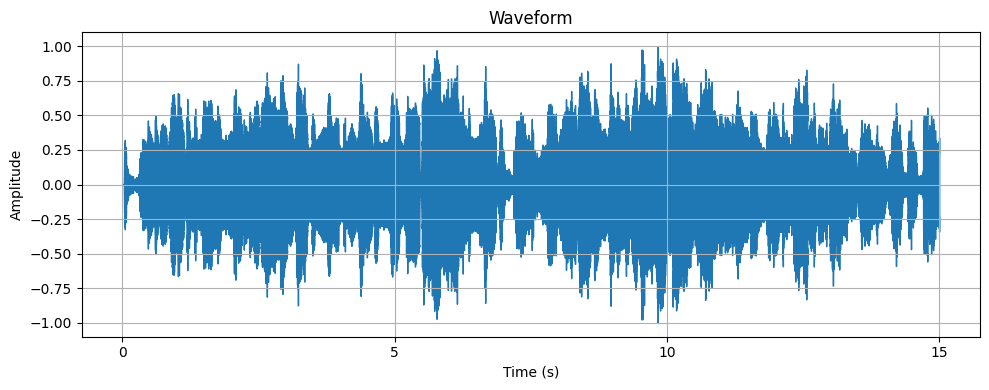

In [ ]:
#Plotting the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y_normalized, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

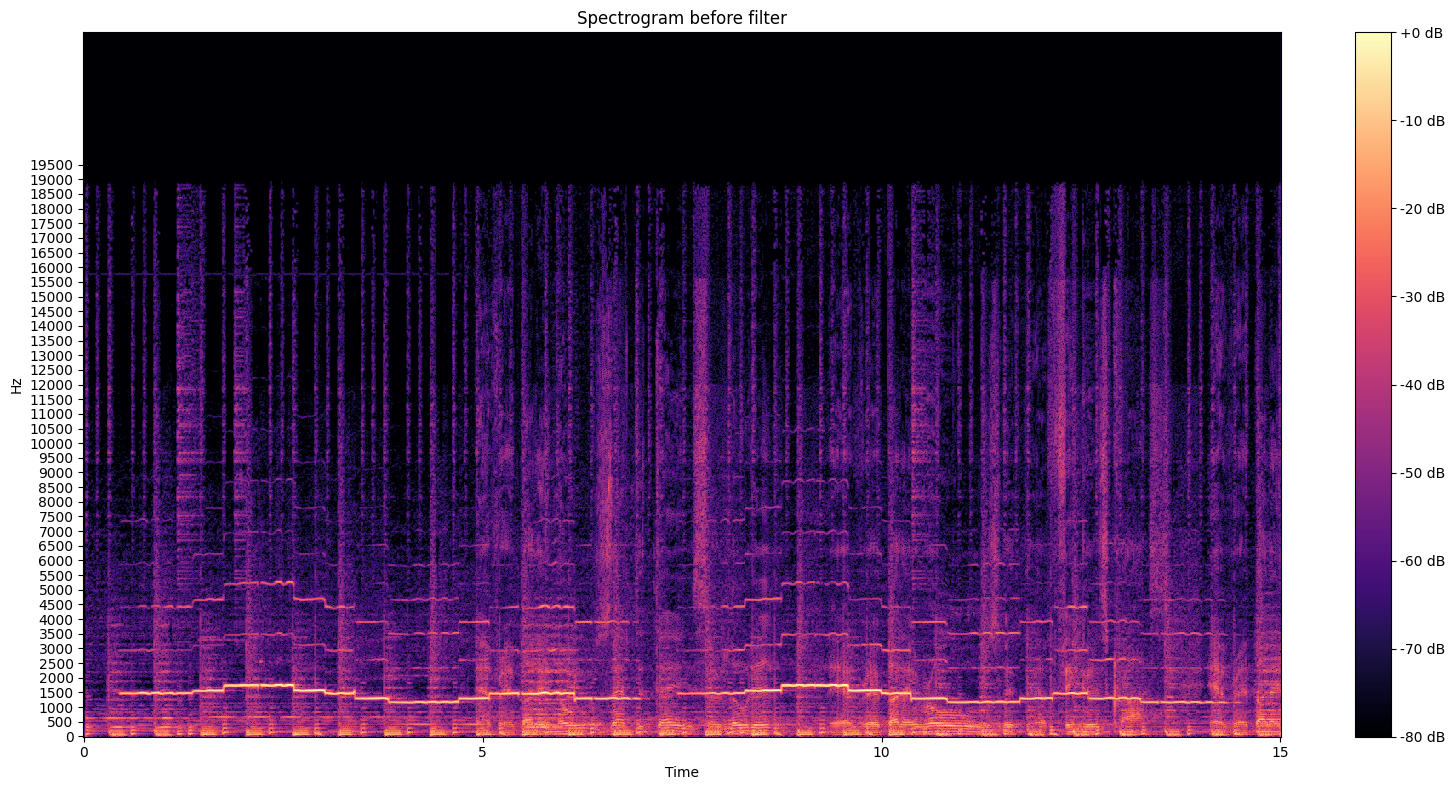

In [ ]:
#Plotting the spectrogram
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(16, 8))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='linear', cmap='magma')
plt.yticks(np.arange(0, 20000, 500))
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram before filter")
plt.tight_layout()
plt.show()

#The given spectrogram shows bright regions in 1500 Hz range and 4000-4500 Hz range which suggests the piccolo sounds might be concentrated here which is further proven by the psd below

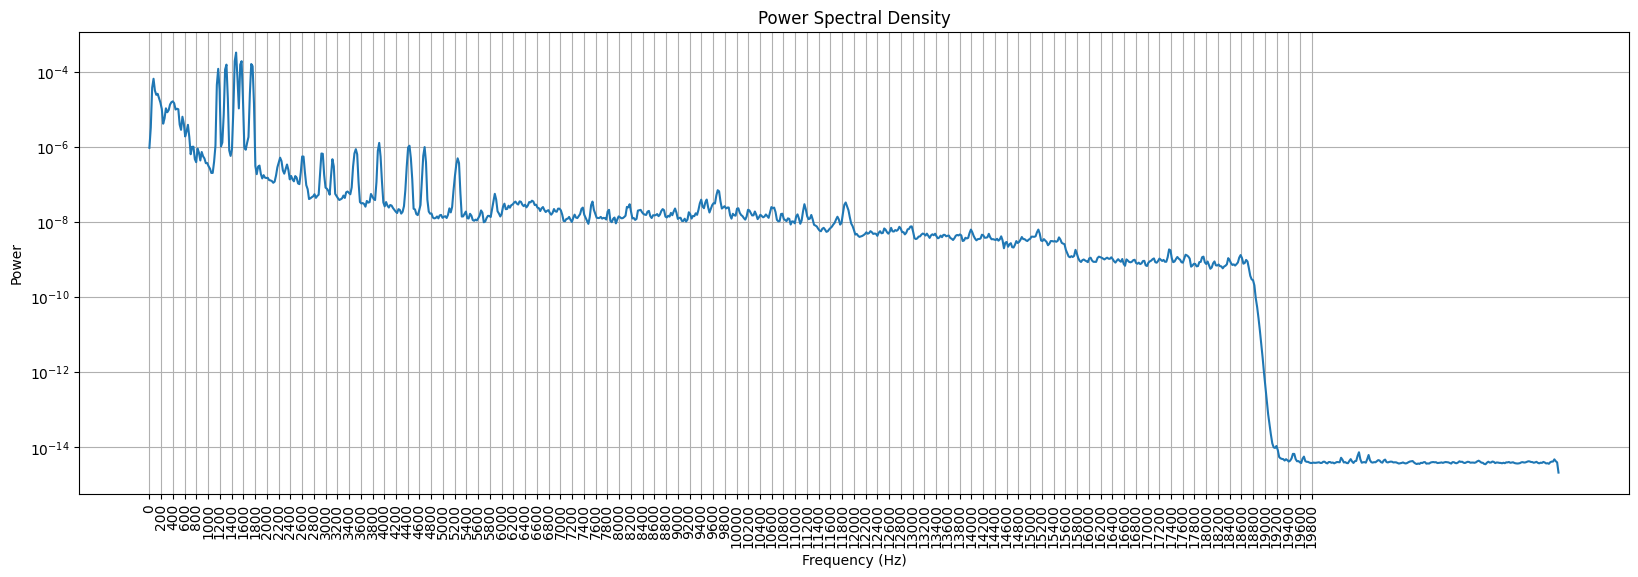

In [ ]:
#Plotting power spectral density
from scipy.signal import welch

frequencies, psd = welch(y, sr, nperseg=2048)

plt.figure(figsize=(20, 6))
plt.semilogy(frequencies, psd)
plt.xticks(np.arange(0, 20000, 200),rotation=90)
plt.title("Power Spectral Density")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.grid()
plt.show()
#As seen from the spectrogram above we see energy peaks in 1000-1800 range and 2600-5000Hz range which suggests the piccolo might be having these frequencies

In [ ]:
#Now of course we can't remove every frequency that is within the above range so we try removing the peaks. We see from the above psd graph that the peaks have a width of 200 Hz on average so we design a notch filter to get rid of all the peaks


from scipy.signal import butter, sosfilt, sosfreqz, find_peaks,iirnotch

#How does find_peaks work? It simply finds the local maxima in the graph whose height is above a certain threshold in this case 1e-10.However in order to ignore the small insignificant peaks it uses peak prominence where
peaks, _ = find_peaks(psd, height=1e-10)
flute_freqs = frequencies[peaks]
flute_freqs_2=frequencies[peaks]

flute_freqs = flute_freqs[(flute_freqs >800) & (flute_freqs < 10000)]
flute_freqs_2 = flute_freqs_2[((flute_freqs_2 >11600) & (flute_freqs_2 < 12000))|((flute_freqs_2 >9400) & (flute_freqs_2 < 10000))|((flute_freqs_2 >14800) & (flute_freqs_2 < 15600))]


print("First peak set:")
for f in flute_freqs:
    print(f"{f:.2f} Hz")

print("Second peak set:")
for f in flute_freqs_2:
    print(f"{f:.2f} Hz")


def notch_filter_sos(freq, fs, bandwidth=200):
   low = max((freq - bandwidth / 2),1)
   high = freq + bandwidth / 2
   sos = butter(2, [low, high], btype='bandstop', fs=fs, output='sos')
   return sos

filtered_y = y.copy()
for f in np.concatenate((flute_freqs_2,flute_freqs)):
    sos = notch_filter_sos(f, sr)
    filtered_y = sosfilt(sos, filtered_y)





First peak set:
820.31 Hz
890.62 Hz
984.38 Hz
1171.88 Hz
1312.50 Hz
1476.56 Hz
1570.31 Hz
1734.38 Hz
1875.00 Hz
1945.31 Hz
2015.62 Hz
2226.56 Hz
2343.75 Hz
2414.06 Hz
2484.38 Hz
2601.56 Hz
2812.50 Hz
2929.69 Hz
3117.19 Hz
3304.69 Hz
3375.00 Hz
3515.62 Hz
3632.81 Hz
3703.12 Hz
3773.44 Hz
3914.06 Hz
4031.25 Hz
4101.56 Hz
4242.19 Hz
4429.69 Hz
4687.50 Hz
4804.69 Hz
4898.44 Hz
4968.75 Hz
5039.06 Hz
5109.38 Hz
5250.00 Hz
5390.62 Hz
5460.94 Hz
5554.69 Hz
5648.44 Hz
5765.62 Hz
5882.81 Hz
6046.88 Hz
6117.19 Hz
6234.38 Hz
6304.69 Hz
6398.44 Hz
6468.75 Hz
6515.62 Hz
6585.94 Hz
6703.12 Hz
6796.88 Hz
6890.62 Hz
6984.38 Hz
7148.44 Hz
7242.19 Hz
7382.81 Hz
7546.88 Hz
7687.50 Hz
7734.38 Hz
7828.12 Hz
7921.88 Hz
7992.19 Hz
8132.81 Hz
8179.69 Hz
8250.00 Hz
8367.19 Hz
8507.81 Hz
8578.12 Hz
8648.44 Hz
8742.19 Hz
8835.94 Hz
8882.81 Hz
8953.12 Hz
9046.88 Hz
9117.19 Hz
9187.50 Hz
9257.81 Hz
9304.69 Hz
9398.44 Hz
9492.19 Hz
9609.38 Hz
9679.69 Hz
9796.88 Hz
9867.19 Hz
9937.50 Hz
Second peak set:
9492.19 Hz
96

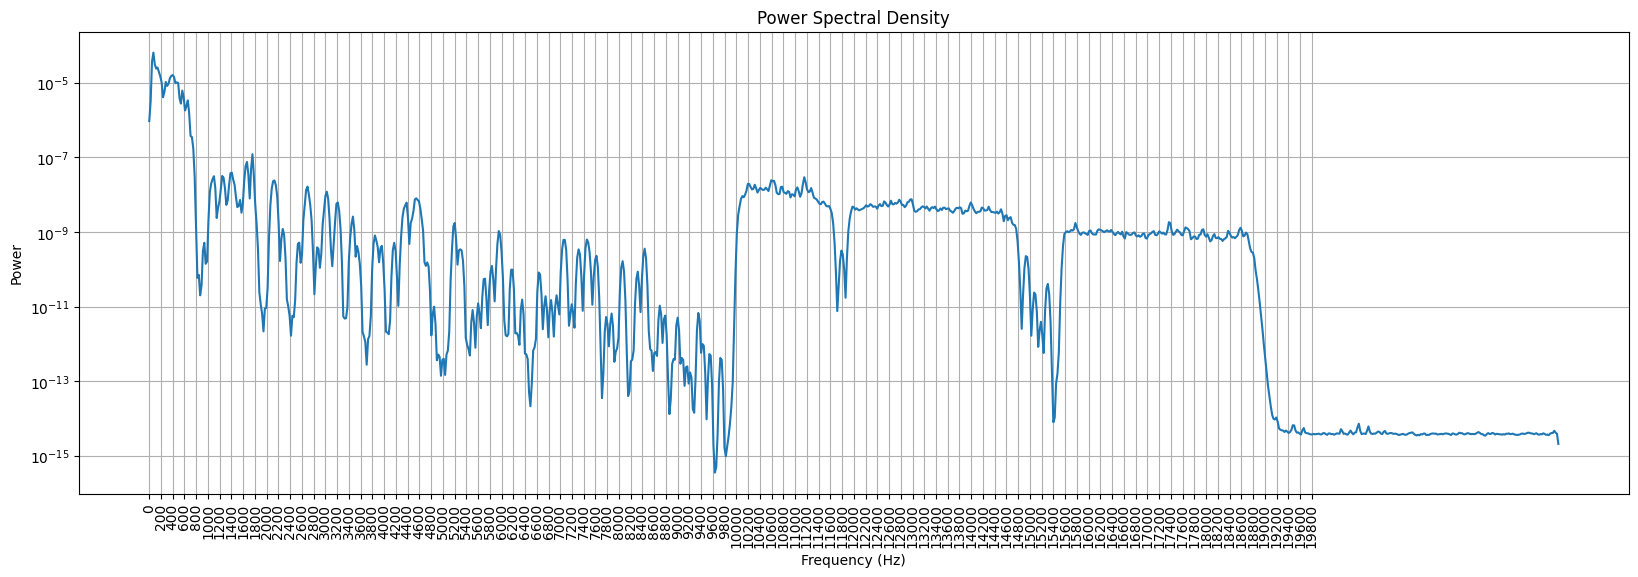

In [ ]:
frequencies, psd = welch(filtered_y, sr, nperseg=2048)

plt.figure(figsize=(20, 6))
plt.semilogy(frequencies, psd)
plt.xticks(np.arange(0, 20000, 200),rotation=90)
plt.title("Power Spectral Density")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.grid()
plt.show()

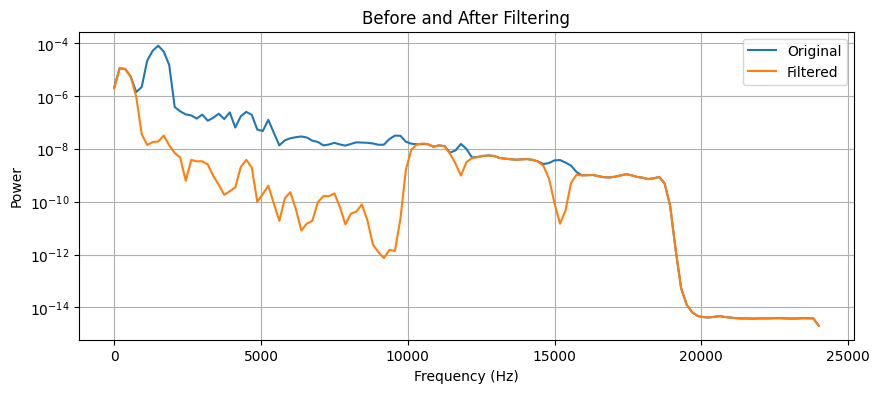

In [ ]:
#Comparison of psd before and after filtering showing attenuation
f1, p1 = welch(y, sr)
f2, p2 = welch(filtered_y, sr)

plt.figure(figsize=(10, 4))
plt.semilogy(f1, p1, label="Original")
plt.semilogy(f2, p2, label="Filtered")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Before and After Filtering")
plt.grid()
plt.show()

In [ ]:
from IPython.display import Audio

Audio(filtered_y, rate=sr)

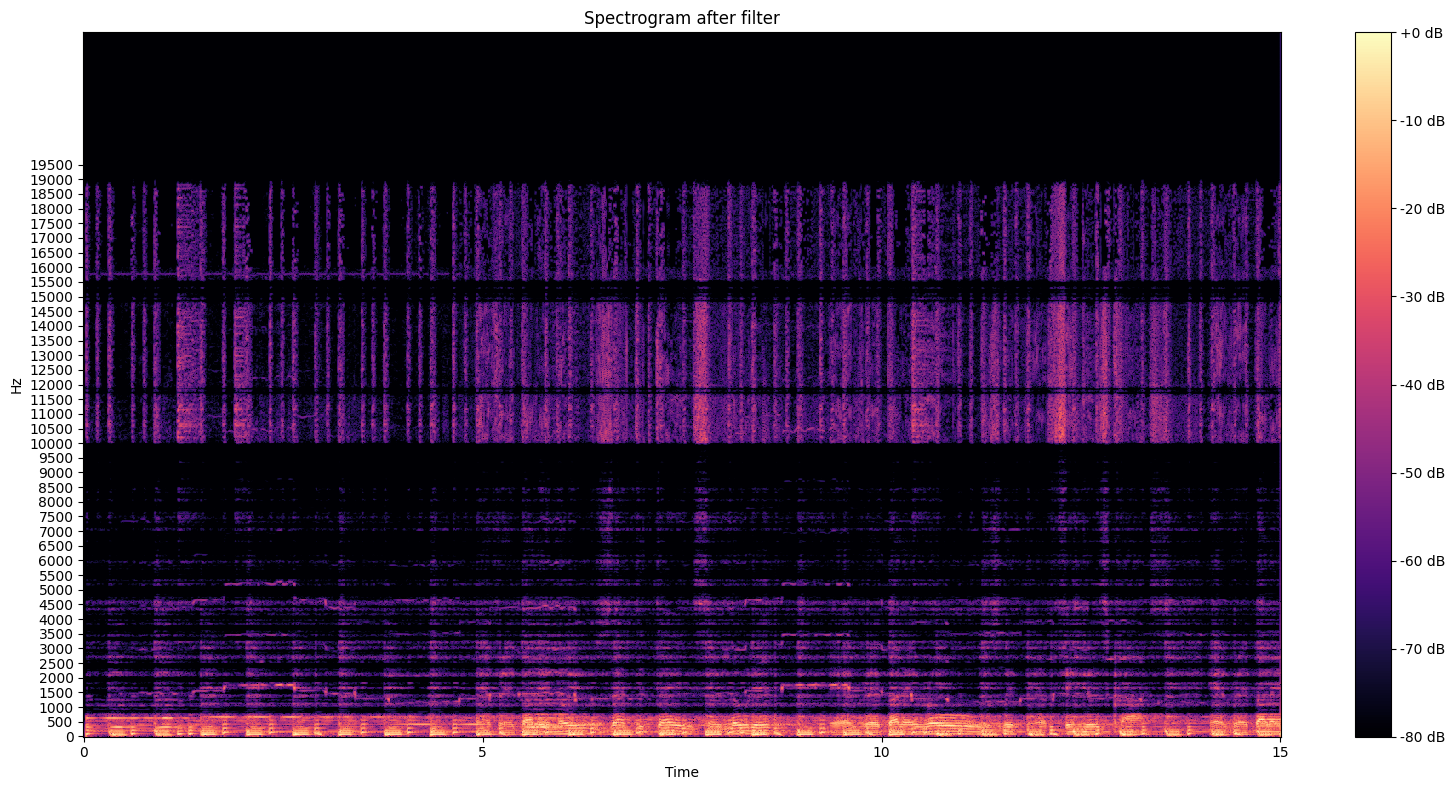

In [ ]:
D = librosa.stft(filtered_y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(16, 8))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='linear', cmap='magma')
plt.yticks(np.arange(0, 20000, 500))
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram after filter")
plt.tight_layout()
plt.show()

In [ ]:
import soundfile as sf
sf.write('song_11.wav', filtered_y, sr)

In [ ]:
#Plotting Bode Plots
def plot_bode(sos, fs):
    w, h = sosfreqz(sos, worN=2000, fs=fs)
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.plot(w, 20 * np.log10(np.abs(h)))
    plt.title('Bode Plot: Magnitude Response')
    plt.ylabel('Magnitude (dB)')
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(w, np.angle(h, deg=True))
    plt.title('Bode Plot: Phase Response')
    plt.ylabel('Phase (degrees)')
    plt.xlabel('Frequency (Hz)')
    plt.grid()

    plt.tight_layout()
    plt.show()



In [ ]:
#Plotting Pole Zero Plots
from scipy.signal import sos2tf,tf2zpk

def plot_polezero(sos):

    b, a = sos2tf(sos)
    z, p, k = tf2zpk(b, a)

    plt.figure(figsize=(6, 6))
    plt.scatter(np.real(z), np.imag(z), c='blue', label='Zeros', marker='o')
    plt.scatter(np.real(p), np.imag(p), c='red', label='Poles', marker='x')
    unit_circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
    plt.gca().add_artist(unit_circle)

    plt.title('Pole-Zero Plot')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.grid()
    plt.axis('equal')
    plt.legend()
    plt.show()


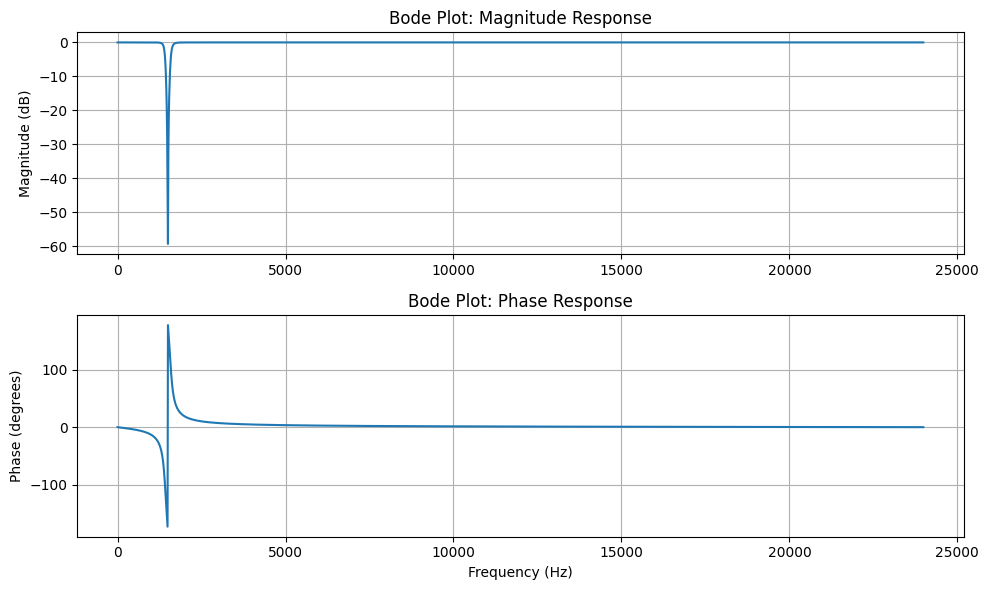

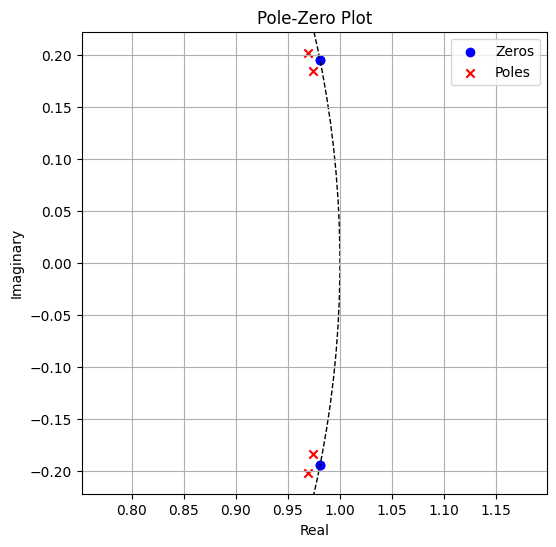

In [ ]:
#For example if my target frequency were 1500 Hz
freq_target=1500
sos = notch_filter_sos(freq_target, sr, 200)
plot_bode(sos, sr)
plot_polezero(sos)